In [192]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import IFrame
from math import sin, cos, acos, radians
import networkx as nx
import requests as req
import json
import pydeck as pdk
import matplotlib.pyplot as plt

In [186]:
data = pd.read_csv('russia_cities.csv')
data

,Unnamed: 0,city,iata,infected,recovered,per100t,lat,lon
0,0,Абакан,ABA,12063,12063,2258.2,53.500000,90.00000
1,1,Анадырь,DYR,389,389,766.9,66.252781,172.00100
2,2,Архангельск,ARH,31230,31230,2859.2,63.500000,43.00000
3,3,Астрахань,ASF,13715,13715,1363.4,47.233330,47.23333
4,4,Барнаул,BAX,26129,26129,1127.7,52.766670,82.61667
...,...,...,...,...,...,...,...,...
63,63,Челябинск,CEK,25249,25249,728.3,54.533330,60.33333
64,64,Чита,HTA,19238,19238,1815.5,54.000000,118.00000
65,65,Элиста,ESL,11658,11658,4301.3,46.566670,45.31667
66,66,Южно-Сахалинск,UUS,11327,11327,2319.0,50.550000,142.60000


In [128]:
data.iloc[i][['lat', 'lon']]

lat       66.4
lon    129.167
Name: 67, dtype: object

In [187]:
layers = []
data = data.sort_values(by=['per100t'], ascending=False).reset_index()
for i in range(len(data.index)):
    color = int((len(data) - i) / len(data) * 255)
    coords = {'lon': data.iloc[i]['lon'], 'lat': data.iloc[i]['lat']}
    layers.append(pdk.Layer(
            'ScatterplotLayer',
            data.loc[data.index == i],
            get_position=['lon', 'lat'],
            get_fill_color=[color, 0, 0, 140],
            get_radius=30000,
            auto_highlight=True,
            pickable=True,
            filled=True
        ))
    
api="pk.eyJ1IjoibWFnaWNkIiwiYSI6ImNrcHR1OGJyZDB2dWoyb21ubXFwcndsYXcifQ.jHeD2GtkzvSIobms7aqUeg"
    
arc_layer = pdk.Deck(
    layers=layers,
    initial_view_state=pdk.ViewState(
        latitude=55.5735,
        longitude=37.5,
        zoom=5,
        pitch=50
    )
)
data = data.sort_values(by=['city']).reset_index()
arc_layer.to_html('map.html')
IFrame(src='map.html', width=700, height=600)


Dropdown(description='Город отправления', options=('Абакан', 'Анадырь', 'Архангельск', 'Астрахань', 'Барнаул',…

Dropdown(description='Город отправления', options=('Абакан', 'Анадырь', 'Архангельск', 'Астрахань', 'Барнаул',…

Button(description='Поиск билетов', style=ButtonStyle())

DatePicker(value=None, description='Дата вылета')

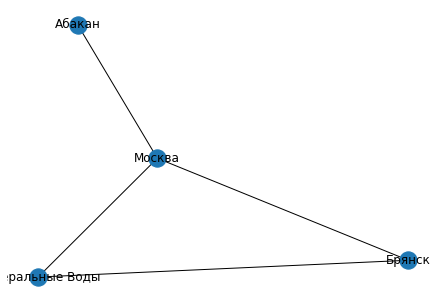

Расстояние между городами в 100км:  64.06716322133246


In [198]:
cities = data['city'].to_list()
city_from = widgets.Dropdown(
    options=cities,
    description='Город отправления',
)
city_to = widgets.Dropdown(
    options=cities,
    description='Город отправления',
)

from_date = widgets.DatePicker(
    description='Дата вылета',
    disabled=False
)

button_find_tickets = widgets.Button(description="Поиск билетов")
button_find_tickets.on_click(find_tickets)
display(city_from, city_to, button_find_tickets, from_date)

In [196]:
def find_tickets(b):
    if (city_from.value == city_to.value):
        print('Вы выбрали одинаковый город для отправления и прибытия')
        return
    from_iata = data[data['city'] == city_from.value]['iata'].values[0]
    to_iata = data[data['city'] == city_to.value]['iata'].values[0]
    lat1 = data[data['city'] == city_from.value]['lat'].values[0]
    lat2 = data[data['city'] == city_to.value]['lat'].values[0]
    lon1 = data[data['city'] == city_from.value]['lon'].values[0]
    lon2 = data[data['city'] == city_to.value]['lon'].values[0]
    
    G = nx.Graph()
    if from_date is None:
        print('Вы не выбрали день вылета')
        return
    y = from_date.value.year
    d = str(from_date.value.day)
    d = '0' * (2 - len(d)) + d
    m = str(from_date.value.month)
    m = '0' * (2 - len(m)) + m
    api = '******'
    url = "https://api.rasp.yandex.net/v3.0/search/?apikey={}&from={}&to={}&format=json&transport_types=plane&date={}-{}-{}&system=iata&transfers=true".format(api, from_iata, to_iata, y, m, d)
    r = req.get(url)
    for subpath in json.loads(r.text)['segments']:
        if 'details' not in subpath:
            subpath = {'details': [subpath]}
        for path in subpath['details'][::2]:
            #print(path)
            from_c = path['from']['popular_title']
            to_c = path['to']['popular_title']
            if from_c not in G.nodes:
                G.add_node(from_c)
            if to_c not in G.nodes:
                G.add_node(to_c)
            G.add_edge(from_c, to_c)
    nx.draw(G, with_labels=True)
    plt.show()
    print("Расстояние между городами в 100км: ", acos(sin(radians(lat1)) * sin(radians(lat2)) + cos(radians(lat1)) * cos(radians(lat2)) * cos(radians(lon2 - lon1))) * 111.3)